# Markowitz portfolio optmization under weight constraints  

In this excercise, we will perform a Markowitz portfolio optimization to an S&P500 equal weight index basket under the constraints that, stock-level weight deviation versus actual index weight is 3%. We rebalance our portfolio from the equal weight basket to the optimized portfolio in X days with no more than 15% daily turnover. We backtest the performance of the optimized portfolio and compare against that of various benchmarks.

Below I summarize a brief list of working assumptions used in the analysis:
1) I can hold fractional shares; short-sale is not allowed
2) There are no tax and transaction cost involved
3) For price data, I use adjusted close from Yahoo Finance
4) I use the current weights of S&P500 (static weights) for the excercise due to limited data availability; SPY (SPX tracking ETF) constituent data is used as a proxy 
5) I use past 5yr data, since many stocks in the current composition do not have a long listing history (say if we use past 10yr data, then 2% of current S&P composition do not have available data); for any stock with missing data due to shorter listing history or M&A events etc, we backfill by the first available close price
6) In the analysis, I separate the data into train and test sets (first four year worth of data as train, and final year data as test). Optimization is done with the train data, performance is evaluated out of sample with the test data
7) For demonstration purposes, I will conduct the analysis using self-defined and public-library functions in this Jupyter notebook. However, it is cleaner and faster to perform the analysis with OOP
8) For risk-free rate, I use the current SOFR Rate, namely 5.30%. In reality, the risk-free rate changes through time and back in history LIBOR was the main benchmark rate
9) I compute covariance matrix from historical daily close prices as risk
10) I use momentum as alpha, the way I define momentum is by 12M - 1M return spread, i.e., 12M momentum + 1M reversal (one of the classic definations)
11) In terms of alpha tilting, there are many ways to do it, my approach is simply to enforce more than 20% total weight on the top momentum quintile stocks and less than 5% total weight on the bottom momentum quintile stocks

## Import related libraries and initialize global variables

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import cvxpy as cp
import yfinance as yf
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")

(CVXPY) Aug 11 02:32:42 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: The specified module could not be found.')
(CVXPY) Aug 11 02:32:42 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: The specified module could not be found.')
(CVXPY) Aug 11 02:32:42 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: The specified module could not be found.')


In [3]:
START_DT = '2018-07-31'
END_DT = '2023-07-31'

STARTING_NOTIONAL = 1e7
PERIODS_PER_ANNUM = 252
PERIODS_PER_MONTH = 21
RISK_FREE_RATE = 5.3 * 1e-2
MAX_WEIGHT_DEVIATION = 3.0 * 1e-2
MAX_DAILY_TURNOVER = 1.5 * 1e-1
PERF_STAT_COLS = ['ret', 'vol', 'sharpe']

## Max volatility used to select the mean-variance optimized weights
MAX_VOL_THRESHOLD = 2.0 * 1e-1

## Upper total weight limit of underweight group of stocks and lower total weight limit of overweight group of stocks
UW_TOTAL_WEIGHT_UPPER_BOUND = 5.0 * 1e-2
OW_TOTAL_WEIGHT_LOWER_BOUND = 2.0 * 1e-1

## Additional buffer days on top of days to trade to execute the rebalance
BUFFER_DAYS = 2.0

## Data download

Get S&P500 tickers & weights by downloading SPY constituent data from a excel file from SSGA official website

In [4]:
## Download tickers and weights from SPY ETF provider
constituents = pd.read_excel(
    'https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx', 
    header=4,
    index_col='Ticker',
).dropna()['Weight']

## Map tickers to Yahoo Finance convention: BRK.B -> BRK-B, BF.B -> BF-B
constituents.index = [i.replace(".", "-")  for i in constituents.index.to_list()]

## Will need to remove the US DOLLAR component from the benchmark portfolio (ticker -)
constituents.drop("-", inplace=True)

## Store list of symbols
symbols = constituents.index.to_list()
num_securities = len(symbols)

Download adj close data from Yahoo Finance

In [5]:
stock_px = yf.download(symbols, start=START_DT, end=END_DT)['Adj Close']
index_px = yf.download(['^SPX'], start=START_DT, end=END_DT)['Adj Close']

[*********************100%***********************]  504 of 504 completed
[*********************100%***********************]  1 of 1 completed


## Data pre-processing

Check the constituent data and re-weigh to ensure 100% total weight

In [6]:
## Need to convert raw weight data to that in percentage terms
constituents /= 100
print(f"Sum of raw weights: {(constituents.sum()).round(5)}")

## Weights do not sum up to 100.00, will need to re-distribute the weights
constituents = constituents / constituents.sum()
print(f"Sum of re-weighed weights: {constituents.sum().round(5)}")

Sum of raw weights: 0.99859
Sum of re-weighed weights: 1.0


In [7]:
## Check missing data
missing_data = stock_px.iloc[0, :].isna()
missing_data_mask = missing_data[missing_data].index
missing_data_weights = constituents[missing_data_mask]
print(f"Tickers which do not have available price data at the start date of the analysis: {missing_data_weights.sum().round(3)}")

## Backfill close data for such tickers
stock_px[missing_data_weights.index] = stock_px[missing_data_mask].fillna(method='bfill')

Tickers which do not have available price data at the start date of the analysis: 0.007


Compute stock and index returns

In [8]:
## For the purpose of portfolio construciton and optimization, simple returns are commonly used
stock_ret = (stock_px / stock_px.shift() - 1).iloc[1:, ]
index_ret = (index_px / index_px.shift() - 1).iloc[1:, ]

We now construct the index portfolio and our starting equal-weight portfolio

In [9]:
## Benchmark portfolio weights
index_weights = constituents.values
ew_weights = 1 / num_securities * np.ones(num_securities)

## Shares are determined at the beginning of the analysis, portfolio performance is the sum of shares * stock_price 
index_port_shares = STARTING_NOTIONAL * index_weights / stock_px.iloc[0, ].values
ew_port_shares = STARTING_NOTIONAL * ew_weights / stock_px.iloc[0, ].values
index_port_perf = (index_port_shares * stock_px).sum(axis=1)
ew_port_perf = (ew_port_shares * stock_px).sum(axis=1)

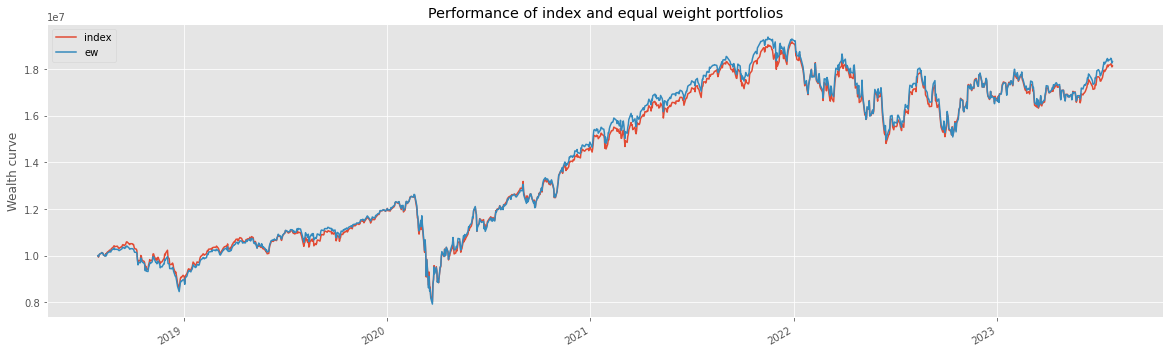

In [10]:
## Plot to check full-history performance of index and equal-weight portfolios
index_port_perf.plot(figsize=(20, 6))
ew_port_perf.plot()

plt.legend(['index', 'ew'])
plt.xlabel("")
plt.ylabel("Wealth curve")
plt.title("Performance of index and equal weight portfolios")
plt.show()

It would seem like index and equal weight portfolios, where weights are fixe at the beginning delivered very similar performance in the past five years

## Portfolio optimization

Recall for Markowitz optimization (mean-variance optimization), we assme market agents all prefer to increase consumption and all are risk-averse.

The utility function is:
$$
U = \mu^T w - \lambda w^T\Sigma w\\
$$

where w is the non-negative weights, mu is the expected return and Sigma is the covariance matrix, and lambda is the risk-aversion parameter

The goal is to solve the below maximization problem
$$
\begin{array}{ll} maximize \medspace \medspace \mu^T w - \lambda w^T\Sigma w\\
subject \medspace to \medspace \medspace \bf 1^T w = 1,\\
\mkern85mu w >= 0,\\
\mkern65mu \quad w \in {\cal W}
\end{array}
$$

The problem is also equivalent to minimizing volatility for a given target return or maximizing expected excess return for a given level of risk tolerance, for example the below formulation:
$$
\begin{array}{ll} maximize \medspace \medspace \mu^T w - r\\
subject \medspace to \medspace \medspace \bf 1^T w = 1,\\
\mkern85mu w >= 0,\\
\mkern85mu \lambda w^T\Sigma w <= tolerance,\\
\mkern65mu \quad w \in {\cal W}
\end{array}
$$

For our specific optimization problem, we have additional constraints on stock-weight deviation versus index. We will maximize expected excess return (expected return - risk free rate r) for a given level of risk tolerance. The formulation of the optimization is:
$$
\begin{array}{ll} maximize \medspace \medspace \mu^T w - r\\
subject \medspace to \medspace \medspace \bf 1^T w = 1,\\
\mkern85mu w >= 0,\\
\mkern85mu \lambda w^T\Sigma w <= 0.2,\\
\mkern85mu max| w - w_b | <= 0.03,\\
\mkern65mu \quad w \in {\cal W}
\end{array}
$$

where w_0 is the starting weights, and w_b is the index benchmark weights

If we also add the alpha tilt, the problem becomes:
$$
\begin{array}{ll} maximize \medspace \medspace \mu^T w - r\\
subject \medspace to \medspace \medspace \bf 1^T w = 1,\\
\mkern85mu w >= 0,\\
\mkern85mu \lambda w^T\Sigma w <= 0.2,\\
\mkern85mu max| w - w_b | <= 0.03,\\
\mkern85mu sum( w_\text{ow} ) >= 0.2,\\
\mkern85mu sum( w_\text{uw} ) <= 0.05,\\
\mkern65mu \quad w \in {\cal W}
\end{array}
$$

where w_ow is weights of the top quintile of stocks which we overweight and the weights of bottom quintile of stocks which we underweight, quintiles decided by alpha rankings

For the sake of comparison, I will implement all the afore mentioned optimized portfolios.

### Optimization

In [11]:
## Copmute annualized mean historical returns mu and covariance matrix Sigma
stock_px_train = stock_px.iloc[:-PERIODS_PER_ANNUM]
stock_ret_train = (stock_px_train.shift() / stock_px_train - 1).iloc[1:, ]
stock_px_test = stock_px.iloc[-PERIODS_PER_ANNUM:]
stock_ret_test = (stock_px_test.shift() / stock_px_test - 1).iloc[1:, ]

mu = ( (stock_px_train.iloc[-1] / stock_px_train.iloc[0]) ** (365 / (stock_px_train.index[-1] - stock_px_train.index[0]).days) - 1 ).values
Sigma = (stock_ret_train.cov() * PERIODS_PER_ANNUM).values

In [12]:
## Compute the shares and perf of the index and equal weight portfolios based on the stock prices on the first trading data of the test data 
index_port_shares_test = STARTING_NOTIONAL * index_weights / stock_px_test.iloc[0, ].values
index_port_perf_test = (stock_px_test * index_port_shares_test).sum(axis=1)

ew_port_shares_test = STARTING_NOTIONAL * ew_weights / stock_px_test.iloc[0, ].values
ew_port_perf_test = (stock_px_test * ew_port_shares_test).sum(axis=1)

In [13]:
## Function to compute the annualized returns, volatility and Sharpe for a portolio of assets with pre-defined weights
def get_port_perf_stats(weights, annaulized_ret, cov_matrix, risk_free_rate=RISK_FREE_RATE):
    port_ret = weights @ annaulized_ret
    port_var = weights @ cov_matrix @ weights.T
    port_vol = np.sqrt(port_var)
    sharpe = (port_ret - risk_free_rate) / port_vol
    return port_ret, port_vol, sharpe

Below we define a wrapper function to find optimized weights, using the cvxpy package

In [14]:
## The function is designed with some flexibility to compare performance of optimization with various constraints
## Constraints are convex
## I use the Embedded Conic Solver, ECOS, to find optimized solution (https://web.stanford.edu/~boyd/papers/pdf/ecos_ecc.pdf) 
def get_optimized_weights(returns, cov_matrix, index_weights=index_weights, risk_free_rate=RISK_FREE_RATE, 
                            max_vol_threshold=MAX_VOL_THRESHOLD, max_weight_deviation=MAX_WEIGHT_DEVIATION,
                            ow_weight_limit=OW_TOTAL_WEIGHT_LOWER_BOUND, uw_weight_limit=UW_TOTAL_WEIGHT_UPPER_BOUND,
                            ow_idx=None, uw_idx=None):
    
    w = cp.Variable(num_securities)
    ret = w @ returns
    risk = w @ cov_matrix @ w.T
    
    objective = cp.Maximize((ret - risk_free_rate))
    constraints = [sum(w) == 1,
                    w >= 0,
                    risk <= max_vol_threshold ** 2
    ]
    if max_weight_deviation is not None:
        constraints.append(cp.abs(w - index_weights) <= max_weight_deviation)
    if (ow_weight_limit is not None) and (uw_weight_limit is not None) and (ow_idx is not None) and (uw_idx is not None):
        constraints.append(cp.sum(w[ow_idx]) >= ow_weight_limit)
        constraints.append(cp.sum(w[uw_idx]) <= uw_weight_limit)

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS)
    
    if problem.status in ['optimal', 'optimal_inaccurate']:
        print(f"Optimization is successful: status is {problem.status}")
        weights = w.value
    else: 
        print(f"Optimization is unsuccessful: status is {problem.status}")
        weights = None
    
    return weights

I use momentum as alpha: I compute 12M - 1M return spread as momentum score, then rank stocks by mom_score. I select the top 50 stocks as the top quintile to overweight and bottom 50 stocks as bottom quintile to underweight. I implement the tilt by enforcing a 5% overweight of the top quintile stocks versus the bottom quintile stocks. 

In [15]:
## Identify overweight and underweight group of stocks based on momentum score measure to add alpha weight tilt 
momentum_measure = stock_px_train.iloc[-1] / stock_px_train.iloc[-(PERIODS_PER_ANNUM + 1)] - stock_px_train.iloc[-1] / stock_px_train.iloc[-(PERIODS_PER_MONTH + 1)]
momentum_measure.name = 'mom_score'
momentum_measure = momentum_measure.reset_index()['mom_score']
momentum_rank = momentum_measure.rank()
top_quintile = momentum_measure[momentum_rank >= 455].index
bottom_quintile = momentum_measure[momentum_rank <= 50].index

For comparison purposes, I also added optimized portfolios with various constraint formulations:
1) vanilla: only constraints are non-negative weights and sum-of-one total weights
2) constrained: additional constraint of weight deviation versus index portfolio less than 3% is added
3) constrainned_with_tilt: additional constraint of total weight of overweight stocks greater than 20%, total weight of underweight stocks less than 5% is also added

In [16]:
## Compute weights for various optimization formulations
optimized_weights = {}

k = 'vanilla'
print(f"######################  {k} optimization  ######################")
optimized_weights[k] = get_optimized_weights(mu, Sigma, max_weight_deviation=None)

k = 'constrained'
print(f"######################  {k} optimization  ######################")
optimized_weights['constrained'] = get_optimized_weights(mu, Sigma)

k = 'constrained_with_tilt'
print(f"######################  {k} optimization  ######################")
optimized_weights['constrained_with_tilt'] = get_optimized_weights(mu, Sigma, ow_idx=top_quintile, uw_idx=bottom_quintile)

######################  vanilla optimization  ######################
Optimization is successful: status is optimal
######################  constrained optimization  ######################
Optimization is successful: status is optimal
######################  constrained_with_tilt optimization  ######################
Optimization is successful: status is optimal


Optimization is successful! We now would like to check whether weight deviation requirements are met:

In [17]:
## Compute maximum stock-level weight deviation from the target optimized portfolio versus the starting equal-weight portfolio  
for k, v in optimized_weights.items():
    print(f"######################  {k} optimization  ######################")
    max_weight_deviation = max(abs(v - index_weights))
    print(f'Max stock-level weight deviation versus index weight for the optimized vanilla portfolio is: {round(max_weight_deviation, 5)}')
    print("")

######################  vanilla optimization  ######################
Max stock-level weight deviation versus index weight for the optimized vanilla portfolio is: 0.16755

######################  constrained optimization  ######################
Max stock-level weight deviation versus index weight for the optimized vanilla portfolio is: 0.03

######################  constrained_with_tilt optimization  ######################
Max stock-level weight deviation versus index weight for the optimized vanilla portfolio is: 0.03



Looks like the stock-level deviation requirements are met fine for the ones with the constraint. 

We can now compare in-sample performance of the optimized portfolio, index and equal_weight portfolio with the portfolio performance statictics function.

In [18]:
## Test in-sample performance of the various optimized portfolio, index and equal-weight portfolios 
optimized_port_perf_stat = []
for _, v in optimized_weights.items():
    perf_stat_temp = get_port_perf_stats(v, mu, Sigma)
    optimized_port_perf_stat.append(perf_stat_temp)

optimized_port_perf_stat = pd.DataFrame(optimized_port_perf_stat, columns=PERF_STAT_COLS, index=optimized_weights.keys())
optimized_port_perf_stat.loc['index'] = get_port_perf_stats(index_weights, mu, Sigma)
optimized_port_perf_stat.loc['ew'] = get_port_perf_stats(ew_weights, mu, Sigma)
optimized_port_perf_stat = optimized_port_perf_stat.round(3)
optimized_port_perf_stat

,ret,vol,sharpe
vanilla,0.477,0.200,2.118
constrained,0.335,0.200,1.409
constrained_with_tilt,0.328,0.200,1.377
index,0.103,0.244,0.206
ew,0.105,0.241,0.215


All the optimized portfolios have below 20% annualized volatility, as requried.

As expected, the optimized portfolios would all have delivered strong results as compared to benchmark portfolios. The optimized portfolios with less constraints would have fared better.

### Rebalance

I now compute the stock_wise shares changes required to rebalance to the target optimized portfolio, and carry out the rebalance in X days with 15% daily turnover limit.

I define the below functions to 1) compute weight turnover and then days to execute the rebalance, 2) compute total shares change needed to reach target portfolio, and shares change trajectory assuming equal amount of shares are traded each trading day and 3) compute the rebalanced portfolio taking into account of the shares change trajectory. 

In [19]:
## Function to calculate days to trade
def optimization_days_to_trade(old_weights, new_weights, max_daily_turnover=MAX_DAILY_TURNOVER, buffer_days=BUFFER_DAYS):
    turnover = sum(abs(new_weights - old_weights))
    days_to_trade = np.ceil(turnover / max_daily_turnover)

    print(f'Turnover from the starting portfolio to target portfolio is: {round(turnover, 2)}')
    print(f'Days to rebalance to the target optimized portfolio is: {days_to_trade}')
    print(f'Additional days to execute the trade to ensure satisfaction of turnover requirement: {buffer_days}')

    return days_to_trade + buffer_days

## Function to compute df of number of shares of the optimized portfolio, as the rebalance is executed. When the rebalance is finished, shares are fixed.
def rebalance_shares(old_shares, new_shares, symbols, days_to_trade, idx):
    shares_df = pd.DataFrame(np.nan, columns=symbols, index=idx)
    shares_to_trade = ((new_shares - old_shares) / days_to_trade)
    shares_df.iloc[0] = old_shares

    for i in range(1, int(days_to_trade + 1)):
        shares_df.iloc[i] = old_shares + shares_to_trade * i
    shares_df.ffill(inplace=True)
    
    return shares_df

## Function to compute final portfolio based on the shares history (taking into account of the rebalance impact), we also compute the impact of rebalance to make sure we meet the requirements
def rebalanced_port_perf(old_shares, new_shares, symbols, days_to_trade, idx, stock_px_df):
    shares_temp = rebalance_shares(old_shares, new_shares, symbols, days_to_trade, idx)
    port_temp = np.multiply(shares_temp, stock_px_df)
    weights_temp = port_temp.div(port_temp.sum(axis=1), axis=0)
    turnover_df_temp = weights_temp.diff().abs().sum(axis=1)
    optimized_perf = port_temp.sum(axis=1)

    print(f'Maximum daily turnover during rebalance is: {round(turnover_df_temp.iloc[:15].max(), 3)}')
    print(f'Total absolute weight deviation from target post rebalance is: {round((weights_temp.iloc[15] - optimized_weights[k]).abs().sum(), 3)}')

    return optimized_perf

In [20]:
## Compute days to carry out the rebalance and shares of target portfolios
optimized_days_to_trade = {}
optimized_target_shares = {}
for k, v in optimized_weights.items():
    print(f"######################  {k} optimization  ######################")
    optimized_days_to_trade[k] = optimization_days_to_trade(ew_weights, v)
    optimized_target_shares[k] = STARTING_NOTIONAL * v / stock_px_test.iloc[0, ].values
    print("")

######################  vanilla optimization  ######################
Turnover from the starting portfolio to target portfolio is: 1.95
Days to rebalance to the target optimized portfolio is: 13.0
Additional days to execute the trade to ensure satisfaction of turnover requirement: 2.0

######################  constrained optimization  ######################
Turnover from the starting portfolio to target portfolio is: 1.86
Days to rebalance to the target optimized portfolio is: 13.0
Additional days to execute the trade to ensure satisfaction of turnover requirement: 2.0

######################  constrained_with_tilt optimization  ######################
Turnover from the starting portfolio to target portfolio is: 1.85
Days to rebalance to the target optimized portfolio is: 13.0
Additional days to execute the trade to ensure satisfaction of turnover requirement: 2.0



It seems like 13 trading days is needed to fully rebalance the equal weighted basket to the target optimized one, with 2 additional buffer days we use to ensure turnover requirement will be met. 

In [21]:
## Compute final portfolio based on the shares history (taking into account of the rebalance impact), we also compute the impact of rebalance to make sure we meet the requirements
optimized_perf = {}
for k in optimized_weights.keys():
    print(f"######################  {k} optimization  ######################")
    optimized_perf[k] = rebalanced_port_perf(ew_port_shares_test, optimized_target_shares[k], symbols, optimized_days_to_trade[k], stock_px_test.index, stock_px_test)
    print("")

######################  vanilla optimization  ######################
Maximum daily turnover during rebalance is: 0.134
Total absolute weight deviation from target post rebalance is: 0.049

######################  constrained optimization  ######################
Maximum daily turnover during rebalance is: 0.126
Total absolute weight deviation from target post rebalance is: 0.052

######################  constrained_with_tilt optimization  ######################
Maximum daily turnover during rebalance is: 0.126
Total absolute weight deviation from target post rebalance is: 0.053



Maximum daily turnover is indeed below 15%. Portoflio weights after rebalance deviate slightly versus that of target portfolio, this is expected since the rebalance is carried out in 15 days, and stock prices have moved.

### Out of sample backtest

We would now like to assess the performance of the aforementioned portfolios out of sample. We define a new function based on portfolio daily price history to assess portfolio performance in a more detailed fashion, where we take a look at max_drawdown, Calmar ratio, Sortino ratio etc.

In [22]:
## Function to compute various performance statistics using portfolio wealth curve history
def get_port_perf_stats_detailed(perf_history, risk_free_rate=RISK_FREE_RATE, annualizing_factor=PERIODS_PER_ANNUM):
    ret_history = (perf_history.shift() / perf_history - 1).iloc[1:, ]
    annualized_ret = ( (perf_history.iloc[-1] / perf_history.iloc[0]) ** (365 / (perf_history.index[-1] - perf_history.index[0]).days) ) - 1
    annualized_vol = ret_history.std() * np.sqrt(annualizing_factor)
    sharpe = (annualized_ret - risk_free_rate) / annualized_vol
    
    rolling_max = perf_history.expanding(min_periods=1).max()
    max_dd = (perf_history / rolling_max - 1).min()
    calmar = - annualized_ret / max_dd
    
    downside_ret = np.where(ret_history < 0, ret_history, 0)
    downside_ret = np.delete(downside_ret, np.where(downside_ret==0))
    annualized_downside_vol = np.sqrt((np.square(downside_ret)).mean() * annualizing_factor)
    sortino = (annualized_ret - risk_free_rate) / annualized_downside_vol
    
    return {"annualized_ret": annualized_ret,
            "annualized_vol": annualized_vol,
            "sharpe": sharpe,
            "max_dd": max_dd,
            "calmar": calmar,
            "sortino": sortino
    }

In [23]:
## Compare out-of-sample porfolio performance using various summary statistics
portfolio_summary_statistics = pd.concat([pd.Series(get_port_perf_stats_detailed(optimized_perf['vanilla'])),
                                            pd.Series(get_port_perf_stats_detailed(optimized_perf['constrained'])),
                                            pd.Series(get_port_perf_stats_detailed(optimized_perf['constrained_with_tilt'])),
                                            pd.Series(get_port_perf_stats_detailed(index_port_perf_test)),
                                            pd.Series(get_port_perf_stats_detailed(ew_port_perf_test))], axis=1).T

portfolio_summary_statistics.index = ['optimized_vanilla', 'optimized_constrained', 'optimized_constrained_with_tilt', 'index', 'ew']
portfolio_summary_statistics = portfolio_summary_statistics.round(3)
portfolio_summary_statistics

,annualized_ret,annualized_vol,sharpe,max_dd,calmar,sortino
optimized_vanilla,0.107,0.164,0.331,-0.100,1.079,0.349
optimized_constrained,0.066,0.169,0.079,-0.146,0.453,0.081
optimized_constrained_with_tilt,0.090,0.167,0.222,-0.135,0.664,0.225
index,0.099,0.191,0.241,-0.160,0.620,0.243
ew,0.107,0.186,0.293,-0.157,0.683,0.292


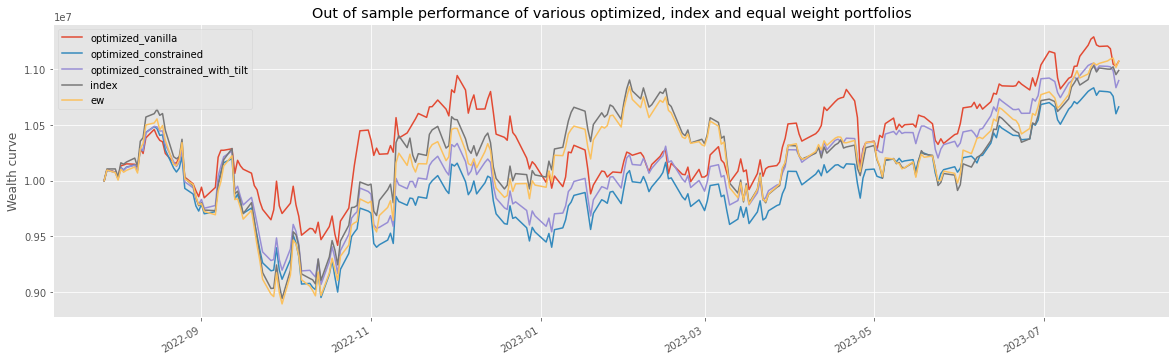

In [24]:
## Out-of-sample performance visulaiton
optimized_perf['vanilla'].plot(figsize=(20, 6))
optimized_perf['constrained'].plot()
optimized_perf['constrained_with_tilt'].plot()
index_port_perf_test.plot()
ew_port_perf_test.plot()

plt.legend(['optimized_vanilla', 'optimized_constrained', 'optimized_constrained_with_tilt', 'index', 'ew'])
plt.xlabel("")
plt.ylabel("Wealth curve")
plt.title("Out of sample performance of various optimized, index and equal weight portfolios")
plt.show()

The optimized portfolios with constraints would actually underperform versus index and equal weight portfolios, which is likely a result of dissimilar environments between train and test data sets, and the past return / covariance matrix from train data fail to represent the performance in the test period. This is somewhat expected given many shifts in the direction of Fed policy etc. In practice, both the train and test periods are usually longer, the optimization should likely enhance performance.

Although we do notice the optimized portfolio with alpha tilt would have outperformed that without the tilt, which suggests adding momentum alpha tilt has helped enhance performance. 